In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sympy import symbols, sin, cos, tan ,exp
from sympy import lambdify
from sympy import S
import sympy as sp

import imfdtd.utils as tfdtd

In [3]:
# Matrix multiplication
def mv_mul(
        matrix_arr:np.ndarray, 
        vector_arr:np.ndarray):
    # Ensure that the shapes of the input arrays are compatible
    assert matrix_arr.shape[:2] == vector_arr.shape[:2], "Shapes of matrix and vector arrays must be the same (N, M)."
    assert matrix_arr.shape[-2:] == (3, 3), "Matrix array must have shape (N, M, 3, 3)."
    assert vector_arr.shape[-1] == 3, "Vector array must have shape (N, M, 3)."

    # Perform element-wise matrix-vector multiplication
    result = np.einsum('ijkl,ijl->ijk', matrix_arr, vector_arr)

    return result

In [4]:
CM = 1E-2
r1= 5*CM
r2 = 10*CM

In [5]:
xlim = np.array([-20*CM, 20*CM])
ylim = np.array([-30*CM, 30*CM])
Points, Fields, Tensor = tfdtd.prepare_simulation([
    xlim,ylim], [200, 300])
E_points, H_points = Points
E_field, H_field = Fields
g_tensor_e, g_tensor_h = Tensor

-0.3 0.3


In [6]:
# Get relative tensor
s_xyz, s_cylinder, s_sph = tfdtd.get_basic_coordinates()
r_s, phi_s, z_s = s_cylinder
R1, R2 = sp.symbols("R_1, R_2")

In [7]:
# Define transformation
u1 = R1 + ((R2- R1)/R1)*r_s
u2 = phi_s
u3 = z_s
eq_coor = [u1.subs([(R1, r1),(R2, r2)]), u2, u3]
syms = [r_s, phi_s, z_s]

In [9]:
gt = tfdtd.get_invisible_tensor(eq_coor, syms, s_xyz)
gt

Matrix([
[(1.0*x**4*sqrt(x**2 + y**2) + 1.0*x**2*y**2*sqrt(x**2 + y**2) + 1.0*y**2*sqrt(x**2 + y**2))/(1.0*x**4 + 2.0*x**2*y**2 + 1.0*y**4), (1.0*x**3*y*sqrt(x**2 + y**2) + 1.0*x*y**3*sqrt(x**2 + y**2) - 1.0*x*y*sqrt(x**2 + y**2))/(1.0*x**4 + 2.0*x**2*y**2 + 1.0*y**4),                     0],
[                                    (1.0*x**3*y + 1.0*x*y**3 - 1.0*x*y)/(1.0*x**2*sqrt(x**2 + y**2) + 1.0*y**2*sqrt(x**2 + y**2)),                                 (1.0*x**2*y**2 + 1.0*x**2 + 1.0*y**4)/(1.0*x**2*sqrt(x**2 + y**2) + 1.0*y**2*sqrt(x**2 + y**2)),                     0],
[                                                                                                                                0,                                                                                                                               0, 1.0*sqrt(x**2 + y**2)]])

In [10]:
gt = gt.inv()

In [11]:
gt.subs([(s_xyz[0], 0),(s_xyz[1], (r1+r2)/3)])

Matrix([
[0.05,    0,    0],
[   0, 20.0,    0],
[   0,    0, 20.0]])

In [16]:
func_gij = tfdtd.get_func_gij([s_xyz[0], s_xyz[1]], gt)

In [28]:
_g_ij = sp.lambdify([s_xyz[0], s_xyz[1]], gt, modules="numpy")

In [23]:
from matplotlib.patches import Ellipse, PathPatch
import  matplotlib.pyplot as plt

In [24]:
#Ellipse
a = r2
b = r2
angle = 0

ellipse_out = Ellipse([0,0], width = a, height =b, angle=angle)
ellipse_in = Ellipse([0,0], width = r1, height=r1)

e_path_out = ellipse_out.get_path()
e_transform_out = ellipse_out.get_transform()
e_path_out_poly = e_transform_out.transform_path(e_path_out)

e_path_in = ellipse_in.get_path()
e_transform_in = ellipse_in.get_transform()
e_path_in_poly = e_transform_in.transform_path(e_path_in)


In [25]:
# Calculate inner points index

Xe,Ye = E_points
n, m = Xe.shape
points = np.vstack([Xe.ravel(), Ye.ravel()]).T
p_bool_out = e_path_out_poly.contains_points(points) #
p_bool_in = e_path_in_poly.contains_points(points)
p_bool  = np.logical_xor(p_bool_out, p_bool_in)
index_r = index_c =  np.where(p_bool)[0]
index_r = (index_r/m).astype(int)
index_c = (index_c%m).astype(int)
bool_array_e = np.zeros((n, m), dtype=bool)
bool_array_e[index_r, index_c] = True

Xh,Yh = H_points
nh, mh = Xh.shape
points_h = np.vstack([Xh.ravel(), Yh.ravel()]).T
p_bool_out_h = e_path_out_poly.contains_points(points_h) #
p_bool_in_h = e_path_in_poly.contains_points(points_h)
p_bool_h  = np.logical_xor(p_bool_out_h, p_bool_in_h)
index_rh = index_ch =  np.where(p_bool_h)[0]
index_rh = (index_rh/mh).astype(int)
index_ch = (index_ch%mh).astype(int)

bool_array_h = np.zeros((nh, mh), dtype=bool)
bool_array_h[index_rh, index_ch] = True


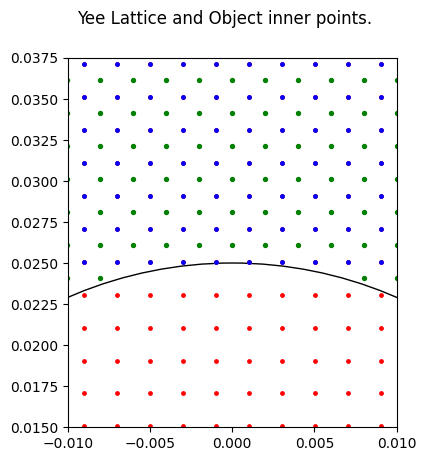

In [26]:
fig, ax = plt.subplots()
e_polygon_out = PathPatch(e_path_out_poly, facecolor='none')
e_polygon_in = PathPatch(e_path_in_poly, facecolor='none')

ax.add_patch(e_polygon_out)
ax.add_patch(e_polygon_in)
ax.scatter(E_points[0], E_points[1], c="r", s=6)

ax.scatter(Xe[bool_array_e], Ye[bool_array_e], c="b", s= 6)
ax.scatter(Xh[bool_array_h], Yh[bool_array_h], c="g", s= 8)

#ax.scatter(H_p[0], H_p[1], c="b", s=10)

ax.set_ylim(0.015, ylim[1]/8)
ax.set_xlim(*xlim/20)
ax.set_aspect('equal', adjustable='box')
fig.suptitle("Yee Lattice and Object inner points.")
plt.show()

In [29]:
Xe_in = Xe[bool_array_e]
Ye_in = Ye[bool_array_e]

In [30]:
_g_ij(Xe_in, Ye_in)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 3) + inhomogeneous part.

In [27]:
Xe_in = Xe[bool_array_e]
Ye_in = Ye[bool_array_e]
gij_in_e = func_gij


Xh_in = Xh[bool_array_h]
Yh_in = Yh[bool_array_h]
gij_in_h = func_gij(Xh_in, Yh_in)


g_tensor_e[bool_array_e, :, :] = gij_in_e
g_tensor_h[bool_array_h, :, :] = gij_in_h

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 3) + inhomogeneous part.

In [36]:
dx = E_points[0][0][1] - E_points[0][0][0]
dy = E_points[0][1][1] - E_points[0][1][0]
dx, dy

(0.002010050251256279, 0.002010050251256279)

In [37]:
E_points, H_points
E_field, H_field
g_tensor_e, g_tensor_h
D_field = E_field

In [38]:
from imfdtd.consts import c0, mu0, ep0

In [39]:
dt = min(dx, dy)/(2*c0)

In [40]:
D_field[...] = 0
E_field[...] = 0
H_field[...] = 0

i=0
t0 =0
dt 

3.3524029668155945e-12

In [41]:
D_field[..., 2] = np.exp(-800*(E_points[0]**2 + E_points[1]**2))

E_field = D_field

H_field[1:, 1:-1, 0] = H_field[1:, 1:-1, 0] + (-0.5)*np.diff(E_field[..., 2], axis=1)
H_field[1:-1, 1:, 1] = H_field[1:-1, 1:, 1] + 0.5*np.diff(E_field[..., 2], axis=0)

## Field time evolution

$$\frac{\partial D_z}{\partial t} = \frac{1}{\sqrt{\epsilon_0 \mu_0}}\left (\frac{\partial H_y}{\partial x} -\frac{\partial H_x}{\partial y}\right)\\
E = \epsilon_r^{-1} D\\
$$

